In [ ]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchsummary import summary
arch = 'resnet18'

# # load the pre-trained weights
# model_file = '%s_places365.pth.tar' % arch
# if not os.access(model_file, os.W_OK):
#     weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
#     print(weight_url)
#     os.system('wget ' + weight_url)
model_file="/content/drive/MyDrive/DeepLearning/SceneClassification/resnet18_places365.pth.tar"
model = models.__dict__["resnet18"](num_classes=365)
# summary(model,(3,277,277))
checkpoint = torch.load(model_file,map_location=lambda storage, loc: storage)
# print(checkpoint['state_dict'].items())
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
# print(state_dict.items())
model.load_state_dict(state_dict,strict=False)
model.eval()
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
     synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
     os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
         classes.append(line.strip().split(' ')[0][3:])
# import inspect

# print(dir(model))
# print(inspect.getsource(model))
# # logit = model.forward(input_img)
# h_x = F.softmax(logit, 1).data.squeeze()

In [ ]:
centre_crop = trn.Compose([
        trn.Resize((256,256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.tensorboard import SummaryWriter
logdir = './logs/func'
writer = SummaryWriter(logdir)

In [ ]:
!unzip  /content/drive/MyDrive/archive.zip


Streaming output truncated to the last 5000 lines.
  inflating: indoorCVPR_09/Images/studiomusic/solarstudio.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio14.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio16.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio2.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio21.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio87.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio99.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio_1.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio_2.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio_a.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio_overall.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studio_pic_for_website.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/studiomusic.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/susustudio.jpg  
  inflating: indoorCVPR_09/Images/studiomusic/trabajo_238115785.jpg 

resnet18 prediction on /content/indoorCVPR_09/Images/auditorium/01_gd_amphi_statues_1__1.jpg
0.308 -> staircase
0.227 -> entrance_hall
0.080 -> throne_room
0.065 -> auditorium
0.050 -> museum/indoor


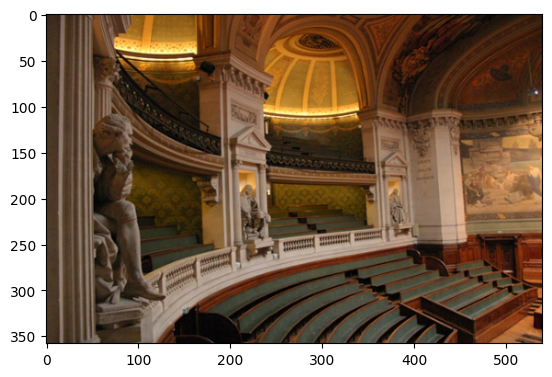

In [ ]:
img_name="/content/indoorCVPR_09/Images/auditorium/01_gd_amphi_statues_1__1.jpg" 

# forward pass
def predict(img_name):
  img = Image.open(img_name)
  input_img = V(centre_crop(img).unsqueeze(0))
  logit = model.forward(input_img)
  h_x = F.softmax(logit, 1).data.squeeze()
  probs, idx = h_x.sort(0, True)
  import matplotlib.pyplot as plt
  plt.imshow(img)
  print('{} prediction on {}'.format(arch,img_name))
  # #output the prediction
  for i in range(0, 5):
      print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
# print(logit)
predict(img_name)

resnet18 prediction on /content/indoorCVPR_09/Images/corridor/050709_bild7_Schulhaus_Korridor.jpg
0.841 -> corridor
0.045 -> porch
0.033 -> arcade
0.015 -> entrance_hall
0.009 -> locker_room


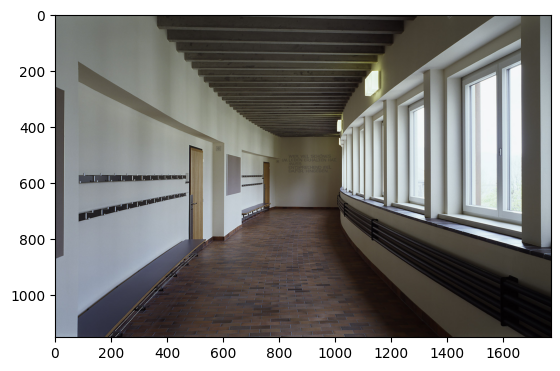

In [ ]:
predict("/content/indoorCVPR_09/Images/corridor/050709_bild7_Schulhaus_Korridor.jpg")

resnet18 prediction on /content/indoorCVPR_09/Images/corridor/Castlereagh_corridor.jpg
0.481 -> corridor
0.113 -> entrance_hall
0.079 -> beauty_salon
0.048 -> elevator_lobby
0.046 -> lobby


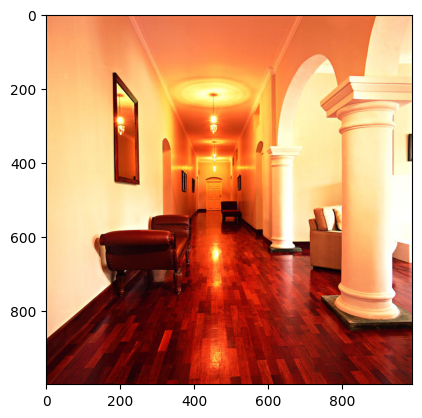

In [ ]:
predict("/content/indoorCVPR_09/Images/corridor/Castlereagh_corridor.jpg")

resnet18 prediction on /content/indoorCVPR_09/Images/corridor/Corridor12.jpg
0.903 -> corridor
0.015 -> utility_room
0.008 -> locker_room
0.007 -> elevator_lobby
0.007 -> closet


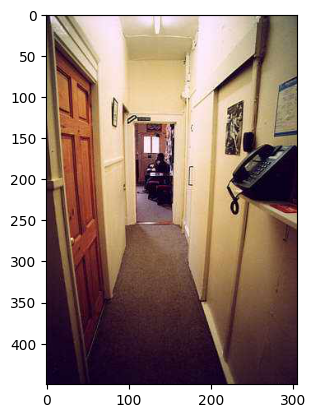

In [ ]:
predict("/content/indoorCVPR_09/Images/corridor/Corridor12.jpg")

resnet18 prediction on /content/drive/MyDrive/DeepLearning/SceneClassification/testingimages/test.jpeg
0.115 -> alley
0.082 -> arcade
0.040 -> medina
0.033 -> elevator_lobby
0.030 -> throne_room


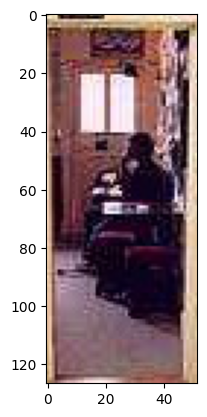

In [ ]:
predict("/content/drive/MyDrive/DeepLearning/SceneClassification/testingimages/test.jpeg")

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import glob
import torchvision

#Data Uploading Class
class MyDataset(Dataset):

    def __init__(self, dataset_path, transform = None):
        super().__init__()
        self.transform = transform
        self.class_paths = glob.glob(dataset_path+'/*')

        self.class_labels={}
        self.file_paths = []
        self.labels = []
        self.len = 0

        for i in range(len(self.class_paths)):
            self.file_paths += glob.glob(self.class_paths[i]+'/*')
            self.labels += len(self.file_paths)*[i]
            self.class_labels[i] = self.class_paths[i].split('/')[-1]

    def __len__(self):
        self.len = len(self.file_paths)
        
        return self.len

    def __getitem__(self, index):

        img = Image.open(self.file_paths[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)

        label = self.labels[index]

        return img, label,self.file_paths[index]

In [ ]:
# mytransform = torchvision.transforms.Compose([transforms.Resize(224),
#                                 transforms.CenterCrop(224),
#                                 transforms.ToTensor()])
#Training and testing dataset loader creation
traindata=MyDataset( dataset_path="/content/indoorCVPR_09/Images/", transform = centre_crop)
print(len(traindata))
print(traindata.class_labels)
valdata=MyDataset( dataset_path="/content/indoorCVPR_09/Images", transform = centre_crop)
print(len(valdata))
train_dataloader = DataLoader(traindata, shuffle=True, num_workers=2, batch_size=1)
test_dataloader = DataLoader(valdata, shuffle=True, num_workers=2, batch_size=len(valdata))

15620
{0: 'meeting_room', 1: 'library', 2: 'poolinside', 3: 'bookstore', 4: 'warehouse', 5: 'locker_room', 6: 'clothingstore', 7: 'florist', 8: 'artstudio', 9: 'buffet', 10: 'cloister', 11: 'concert_hall', 12: 'tv_studio', 13: 'subway', 14: 'corridor', 15: 'nursery', 16: 'studiomusic', 17: 'trainstation', 18: 'museum', 19: 'hairsalon', 20: 'bar', 21: 'jewelleryshop', 22: 'closet', 23: 'movietheater', 24: 'dining_room', 25: 'laundromat', 26: 'bowling', 27: 'toystore', 28: 'bathroom', 29: 'casino', 30: 'stairscase', 31: 'winecellar', 32: 'office', 33: 'airport_inside', 34: 'operating_room', 35: 'gameroom', 36: 'hospitalroom', 37: 'inside_subway', 38: 'fastfood_restaurant', 39: 'kindergarden', 40: 'elevator', 41: 'waitingroom', 42: 'children_room', 43: 'restaurant_kitchen', 44: 'videostore', 45: 'garage', 46: 'mall', 47: 'kitchen', 48: 'greenhouse', 49: 'lobby', 50: 'classroom', 51: 'livingroom', 52: 'church_inside', 53: 'shoeshop', 54: 'laboratorywet', 55: 'bakery', 56: 'auditorium', 57:

In [ ]:
from torch.utils.tensorboard import SummaryWriter
logdir = './logs/func'
writer = SummaryWriter(logdir)
labesl,images=next(iter(train_dataloader))
writer.add_graph(model,labesl)

writer.flush()
%load_ext tensorboard
%tensorboard --logdir ./logs/func

ValueError: ignored

In [ ]:
# model.fc=torch.nn.Linear(512,67)
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# summary(model,(3,227,227))
# from torch.utils.tensorboard import SummaryWriter
# logdir = './logs/func'
# writer = SummaryWriter(logdir)

In [ ]:
for param in model.parameters():
      param.requires_grad = False

#UnFreezing the last two layers parameters
for param in model.fc.parameters():
    print(param)
    param.requires_grad = True

Parameter containing:
tensor([[ 0.0064, -0.0173, -0.0207,  ...,  0.0038, -0.0358, -0.0233],
        [ 0.0126, -0.0069, -0.0101,  ...,  0.0289,  0.0060, -0.0048],
        [ 0.0077, -0.0067,  0.0090,  ..., -0.0018,  0.0249,  0.0324],
        ...,
        [ 0.0338,  0.0074,  0.0197,  ..., -0.0295, -0.0288,  0.0339],
        [-0.0142, -0.0196,  0.0095,  ..., -0.0093,  0.0439,  0.0176],
        [ 0.0350,  0.0277,  0.0082,  ...,  0.0029,  0.0157,  0.0187]])
Parameter containing:
tensor([ 0.0104,  0.0434, -0.0168, -0.0202,  0.0070,  0.0156, -0.0166,  0.0134,
        -0.0228,  0.0416, -0.0170,  0.0425, -0.0034,  0.0329, -0.0355,  0.0187,
         0.0155, -0.0010, -0.0123, -0.0077,  0.0413,  0.0006,  0.0380, -0.0179,
        -0.0070,  0.0210, -0.0419,  0.0015,  0.0034,  0.0344,  0.0371,  0.0220,
         0.0230, -0.0106, -0.0338, -0.0131,  0.0235, -0.0012,  0.0409,  0.0382,
        -0.0066,  0.0076, -0.0084,  0.0078, -0.0035, -0.0309, -0.0262, -0.0251,
        -0.0219, -0.0168, -0.0426, -0.0133

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# def train():
#     model.train()   
#     loss=0
#     running_loss = 0.0
#     train_acc=0
#     for i, data in enumerate(train_dataloader, 0):
#         inputs, labels = data
#         inputs=inputs
#         labels=labels
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         _,predict=torch.max(outputs,1)
#         train_acc+=(predict == labels).sum().item()
#         running_loss += loss.item()
#     return train_acc/len(traindata),running_loss/len(train_dataloader)

# def test(): 
#     model.eval()   
#     loss=0
#     running_loss = 0.0
#     test_acc=0
#     for i, data in enumerate(test_dataloader, 0):
#         inputs, labels = data
#         inputs, labels = data
#         inputs=inputs
#         labels=labels
#         outputs = model(inputs.to(device))
#         loss = criterion(outputs, labels)
#         _,predict=torch.max(outputs,1)
#         test_acc+=(predict == labels).sum().item()
#         running_loss += loss.item()
#     return running_loss/len(test_dataloader),test_acc / len(valdata)

# print("Model Training")
# for epoch in range(5):
#   train_acc,train_los=train()
#   test_acc,test_los=train()
#   print(f'Epoch: {epoch + 1} Training loss: {train_los:.3f} Testing loss: {test_los:.3f} Train Accracy: {train_acc*100:.3f}% Test Accracy: {test_acc*100:.3f}%')
#   writer.add_scalar("Loss/test", test_los, epoch+1)
#   writer.add_scalar("accuracy/test", test_acc, epoch+1)
#   writer.add_scalar("Loss/train", train_los, epoch+1)
#   writer.add_scalar("accuracy/train",train_acc, epoch+1)
#   writer.add_scalars('ModelAccuracy', {'train': train_acc,'test': test_acc}, epoch+1)
#   writer.add_scalars('ModelLoss', {'train': train_los,'test': test_los}, epoch+1)

In [ ]:
def test(): 
     model.eval()   
     loss=0
     running_loss = 0.0
     test_acc=0
     for i, data in enumerate(test_dataloader, 0):
         inputs, labels = data
         inputs, labels = data
         inputs=inputs
         labels=labels
         outputs = model(inputs.to(device))
         loss = criterion(outputs, labels)
         _,predict=torch.max(outputs,1)
         test_acc+=(predict == labels).sum().item()
         running_loss += loss.item()
     return running_loss/len(test_dataloader),test_acc / len(valdata)
test,arr=test()

KeyboardInterrupt: ignored

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-147-gaa7c45c Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.2/78.2 GB disk)


In [ ]:
weigths_path="/content/drive/MyDrive/DeepLearning/SceneClassification/IOD155_YOLOv5L_model.pt"

!python detect.py --weights weigths_path --img 640 --conf 0.25 --source data/images
# display.Image(filename="/content/indoorCVPR_09/Images/corridor/Corridor12.jpg", width=600)

detect: weights=['weigths_path'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-147-gaa7c45c Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Traceback (most recent call last):
  File "/content/yolov5/detect.py", line 261, in <module>
    main(opt)
  File "/content/yolov5/detect.py", line 256, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/content/yolov5/detect.py", line 98, in run
    model = DetectMultiBa

In [ ]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True)  # yolov5n - yolov5x6 or custom
im = "/content/indoorCVPR_09/Images/corridor/Corridor12.jpg" # file, Path, PIL.Image, OpenCV, nparray, list
results = model(im)  # inference
results.print()  # or .show(), .save(), .crop(), .pandas(), etc.

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 v7.0-147-gaa7c45c Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)



requirements: /content/requirements.txt not found, check failed.


100%|██████████| 14.1M/14.1M [00:00<00:00, 20.2MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
image 1/1: 450x305 1 person
Speed: 32.2ms pre-process, 61.3ms inference, 24.1ms NMS per image at shape (1, 3, 640, 448)


In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', classes=155)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-147-gaa7c45c Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Overriding model.yaml nc=80 with nc=155

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3

requirements: /content/requirements.txt not found, check failed.


  8                -1  1   1182720  models.common.C3                        [512, 512, 1]                 
  9                -1  1    656896  models.common.SPPF                      [512, 512, 5]                 
 10                -1  1    131584  models.common.Conv                      [512, 256, 1, 1]              
 11                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 12           [-1, 6]  1         0  models.common.Concat                    [1]                           
 13                -1  1    361984  models.common.C3                        [512, 256, 1, False]          
 14                -1  1     33024  models.common.Conv                      [256, 128, 1, 1]              
 15                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 16           [-1, 4]  1         0  models.common.Concat                    [1]                           
 17                -1  1     90880  m

In [ ]:
checkpoint = torch.load(weigths_path)
print(checkpoint)
# print(checkpoint['state_dict'].items())
# state_dict = {str.replace(k,'model.',''): v for k,v in checkpoint['model'].items()}
# print(state_dict.items())
# model.load_state_dict(state_dict,strict=False)

{'epoch': -1, 'best_fitness': array([    0.34143]), 'training_results': None, 'model': DetectionModel(
  (model): Sequential(
    (0): Focus(
      (conv): Conv(
        (conv): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU()
      )
    )
    (1): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU()
      )
      (cv2): Conv(
        (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0

In [ ]:
model = torch.hub.load("ultralytics/yolov5", 'custom', path="/content/drive/MyDrive/DeepLearning/SceneClassification/IOD155_YOLOv5L_model.pt")

requirements: /content/requirements.txt not found, check failed.


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-147-gaa7c45c Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 392 layers, 47429856 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
im = "/content/indoorCVPR_09/Images/corridor/Corridor12.jpg" # file, Path, PIL.Image, OpenCV, nparray, list
results = model(im)  # inference
results.print()  # or .show(), .save(), .crop(), .pandas(), etc.

image 1/1: 450x305 1 Door
Speed: 8.0ms pre-process, 94.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 448)


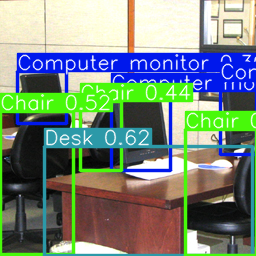

image 1/1: 256x256 3 Chairs, 1 Desk, 3 Computer monitors
Speed: 23.6ms pre-process, 111.4ms inference, 2.0ms NMS per image at shape (1, 3, 640, 640)


,xmin,ymin,xmax,ymax,confidence,class,name
0,185.398300,129.852905,256.000000,255.927902,0.642751,25,Chair
1,44.993446,146.475098,252.952499,255.417709,0.623454,30,Desk
2,0.000000,111.688011,73.363487,254.735840,0.519045,25,Chair
3,220.670929,80.570717,256.000000,154.284927,0.515917,34,Computer monitor
4,80.552605,101.089767,121.996887,170.036453,0.444093,25,Chair
5,111.614647,91.835075,170.648911,170.477966,0.377828,34,Computer monitor
6,17.122894,71.564262,66.586868,123.051407,0.296078,34,Computer monitor


In [ ]:
result=model("/content/indoorCVPR_09/Images/computerroom/12_student_classroom_4_computer_training_1.jpg")
result.show()
result.print()
result.pandas().xyxy[0] 

In [ ]:
# traindata=MyDataset( dataset_path="/content/indoorCVPR_09/Images/", transform = centre_crop)
# print(len(traindata))
# print(traindata.class_labels)
# valdata=MyDataset( dataset_path="/content/indoorCVPR_09annotations/Annotations", transform = centre_crop)
# print(len(valdata))
# train_dataloader
image,label,path=next(iter(train_dataloader))
# print(traindata[0])
result=model(path)
# result
# result.show()
# result.print()
b=result.pandas().xyxy[0]
import numpy as np
zarray = np.zeros(155)
k=[];
for g in b["class"]:
  if g in k:
    zarray[g]+=1
  else:
    zarray[g]=1
  k.append(g)
print(zarray)
result.pandas().xyxy[0]

[          0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           2
           0           0           0           0           1           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0
           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0
           0           0           0           0           0 

,xmin,ymin,xmax,ymax,confidence,class,name
0,941.233704,893.548035,1442.572754,1629.823120,0.852159,25,Chair
1,1868.851807,898.046326,2358.359619,1648.680786,0.735735,25,Chair
2,1527.252686,506.952545,1806.265259,856.408447,0.376599,98,Picture frame
3,1455.425171,1055.757568,1855.846558,1570.790039,0.272053,30,Desk
